Resources Used
- wget.download('https://tensorflow-object-detection-api-tutorial.readthedocs.io/en/latest/_downloads/da4babe668a8afb093cc7776d7e630f3/generate_tfrecord.py')
- Setup https://tensorflow-object-detection-api-tutorial.readthedocs.io/en/latest/install.html

# 0. Setup Paths - Define as pastas e variáveis

In [1]:
WORKSPACE_PATH = 'Tensorflow/workspace'  
SCRIPTS_PATH = 'Tensorflow/scripts'
APIMODEL_PATH = 'Tensorflow/models'
ANNOTATION_PATH = WORKSPACE_PATH+'/annotations'
IMAGE_PATH = WORKSPACE_PATH+'/images'
MODEL_PATH = WORKSPACE_PATH+'/models'
PRETRAINED_MODEL_PATH = WORKSPACE_PATH+'/pre-trained-models'
CONFIG_PATH = MODEL_PATH+'/my_ssd_mobnet/pipeline.config'
CHECKPOINT_PATH = MODEL_PATH+'/my_ssd_mobnet/'

# 1. Create Label Map

In [2]:
labels = [{'name':'lemon', 'id':1}]

with open(ANNOTATION_PATH + '\label_map.pbtxt', 'w') as f:
    for label in labels:
        f.write('item { \n')
        f.write('\tname:\'{}\'\n'.format(label['name']))
        f.write('\tid:{}\n'.format(label['id']))
        f.write('}\n')

# 2. Create TF records

In [2]:
!python {SCRIPTS_PATH + '/generate_tfrecord.py'} -x {IMAGE_PATH + '/train'} -l {ANNOTATION_PATH + '/label_map.pbtxt'} -o {ANNOTATION_PATH + '/train.record'}
!python {SCRIPTS_PATH + '/generate_tfrecord.py'} -x{IMAGE_PATH + '/test'} -l {ANNOTATION_PATH + '/label_map.pbtxt'} -o {ANNOTATION_PATH + '/test.record'}

Successfully created the TFRecord file: Tensorflow/workspace/annotations/train.record
Successfully created the TFRecord file: Tensorflow/workspace/annotations/test.record


# 3. Download TF Models Pretrained Models from Tensorflow Model Zoo

In [4]:
!cd Tensorflow && git clone https://github.com/tensorflow/models

Cloning into 'models'...


In [6]:
#wget.download('http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz')
#!mv ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz {PRETRAINED_MODEL_PATH}
#!cd {PRETRAINED_MODEL_PATH} && tar -zxvf ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz

# 4. Copy Model Config to Training Folder

In [2]:
CUSTOM_MODEL_NAME = 'my_ssd_mobnet' 

In [3]:
!mkdir {'Tensorflow\workspace\models\\'+CUSTOM_MODEL_NAME}
!cp {PRETRAINED_MODEL_PATH+'/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/pipeline.config'} {MODEL_PATH+'/'+CUSTOM_MODEL_NAME}

J  existe uma subpasta ou um arquivo Tensorflow\workspace\models\my_ssd_mobnet.
'cp' nÆo ‚ reconhecido como um comando interno
ou externo, um programa oper vel ou um arquivo em lotes.


# 5. Update Config For Transfer Learning

In [4]:
import tensorflow as tf
from object_detection.utils import config_util
from object_detection.protos import pipeline_pb2
from google.protobuf import text_format

In [5]:
CONFIG_PATH = MODEL_PATH+'/'+CUSTOM_MODEL_NAME+'/pipeline.config'

In [6]:
config = config_util.get_configs_from_pipeline_file(CONFIG_PATH)

In [7]:
config

{'model': ssd {
   num_classes: 5
   image_resizer {
     fixed_shape_resizer {
       height: 320
       width: 320
     }
   }
   feature_extractor {
     type: "ssd_mobilenet_v2_fpn_keras"
     depth_multiplier: 1.0
     min_depth: 16
     conv_hyperparams {
       regularizer {
         l2_regularizer {
           weight: 4e-05
         }
       }
       initializer {
         random_normal_initializer {
           mean: 0.0
           stddev: 0.01
         }
       }
       activation: RELU_6
       batch_norm {
         decay: 0.997
         scale: true
         epsilon: 0.001
       }
     }
     use_depthwise: true
     override_base_feature_extractor_hyperparams: true
     fpn {
       min_level: 3
       max_level: 7
       additional_layer_depth: 128
     }
   }
   box_coder {
     faster_rcnn_box_coder {
       y_scale: 10.0
       x_scale: 10.0
       height_scale: 5.0
       width_scale: 5.0
     }
   }
   matcher {
     argmax_matcher {
       matched_threshold: 0.5
    

In [8]:
pipeline_config = pipeline_pb2.TrainEvalPipelineConfig()
with tf.io.gfile.GFile(CONFIG_PATH, "r") as f:                                                                                                                                                                                                                     
    proto_str = f.read()                                                                                                                                                                                                                                          
    text_format.Merge(proto_str, pipeline_config)  

In [9]:
pipeline_config.model.ssd.num_classes = 5
pipeline_config.train_config.batch_size = 4
pipeline_config.train_config.fine_tune_checkpoint = PRETRAINED_MODEL_PATH+'/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/ckpt-0'
pipeline_config.train_config.fine_tune_checkpoint_type = "detection"
pipeline_config.train_input_reader.label_map_path= ANNOTATION_PATH + '/label_map.pbtxt'
pipeline_config.train_input_reader.tf_record_input_reader.input_path[:] = [ANNOTATION_PATH + '/train.record']
pipeline_config.eval_input_reader[0].label_map_path = ANNOTATION_PATH + '/label_map.pbtxt'
pipeline_config.eval_input_reader[0].tf_record_input_reader.input_path[:] = [ANNOTATION_PATH + '/test.record']

In [10]:
config_text = text_format.MessageToString(pipeline_config)                                                                                                                                                                                                        
with tf.io.gfile.GFile(CONFIG_PATH, "wb") as f:                                                                                                                                                                                                                     
    f.write(config_text)   

# 6. Train the model

In [11]:
print("""python {}/research/object_detection/model_main_tf2.py --model_dir={}/{} --pipeline_config_path={}/{}/pipeline.config --num_train_steps=5000""".format(APIMODEL_PATH, MODEL_PATH,CUSTOM_MODEL_NAME,MODEL_PATH,CUSTOM_MODEL_NAME))

python Tensorflow/models/research/object_detection/model_main_tf2.py --model_dir=Tensorflow/workspace/models/my_ssd_mobnet --pipeline_config_path=Tensorflow/workspace/models/my_ssd_mobnet/pipeline.config --num_train_steps=5000


# 7. Load Train Model From Checkpoint

In [11]:
import os
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder

In [12]:
# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(CONFIG_PATH)
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(CHECKPOINT_PATH, 'ckpt-6')).expect_partial()

@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

# 8. Detect in Real-Time

In [13]:
import cv2 
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [14]:
category_index = label_map_util.create_category_index_from_labelmap(ANNOTATION_PATH+'/label_map.pbtxt')

In [16]:
category_index

{1: {'id': 1, 'name': 'lemon'}}

In [20]:
cap = cv2.VideoCapture(0)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
detection_threshold = 0.7

while (cap.isOpened()):
    
    
    ret, frame = cap.read()
    image_np = np.array(frame)
    
    if(ret == True):
        
        #Converte os valorés do array np para float
        input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
        #Carregue o modelo salvo e crie a função de detecção
        detections = detect_fn(input_tensor)

        #Agarra o número de detecções
        num_detections = int(detections.pop('num_detections'))
        #Realiza o pre-processamento dos dados np
        detections = {key: value[0, :num_detections].numpy() for key, value in detections.items()}
        detections['num_detections'] = num_detections
        # Converter para inteiros
        detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

        label_id_offset = 1
        image_np_with_detections = image_np.copy()

        viz_utils.visualize_boxes_and_labels_on_image_array(
                    image_np_with_detections,
                    detections['detection_boxes'],
                    detections['detection_classes']+label_id_offset,
                    detections['detection_scores'],
                    category_index,
                    use_normalized_coordinates=True,
                    max_boxes_to_draw=50,
                    min_score_thresh=.20,
                    skip_scores= True,
                    skip_labels= True,
                    agnostic_mode=False)

        scores = list(filter(lambda x: x> detection_threshold, 
        detections['detection_scores']))
        boxes = detections['detection_boxes'][:len(scores)]
        classes = detections['detection_classes'][:len(scores)]

        width = image_np_with_detections.shape[1]
        height = image_np_with_detections.shape[0]
        
        for idx, box in enumerate(boxes):
            
            roi = box*[height, width, height, width]
            
            #Area de corte da imagem

            xt = roi[1]
            xb = roi[3]
            yt = roi[0]
            yb = roi[2]
        
            #Regiao de interesse

            Lmax = abs(xt - xb)
            Hmax = abs(yt - yb)

            RoiL = 0.5 * Lmax
            RoiH = 0.5 * Hmax

            #Esses coordenadas são as que vão delimitar a area onde a imagem vai ser cortada

            centro = (xb + xt) / 2

            centroCaixa = RoiL / 2

            x1 = centro - centroCaixa
            x2 = centro + centroCaixa

            y1 = abs(yt - 5)
            y2 = abs(RoiH - y1)

            x1 = int(x1)
            y1 = int(y1)
            x2 = int(x2)
            y2 = int(y2)

            TopLeftY = y2
            TopLeftX = x1

            cv2.rectangle(image_np_with_detections, (x2, y2), (x1,y1), (255,255,0), 1)
      
        cv2.imshow('object detection',  cv2.resize(image_np_with_detections, (1920, 1080)))

        if cv2.waitKey(1) & 0xFF == ord("q"):
            break
            
        
             

cap.release()
cv2.destroyAllWindows()

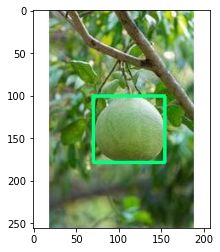

In [22]:
img = cv2.imread("(81).jpg")
image_np = np.array(img)

input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
detections = detect_fn(input_tensor)

num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
              for key, value in detections.items()}
detections['num_detections'] = num_detections

detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

label_id_offset = 1
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'],
            detections['detection_classes']+label_id_offset,
            detections['detection_scores'],
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=5,
            min_score_thresh=.8,
            skip_scores= True,
            skip_labels= True,
            agnostic_mode=False)

plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
plt.show()